In [1]:
!pip install -q fastbook

import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *

# 1. Data loading and augmentation

Create a DataBlock and DataLoaders using:
- Training and validation images collected in Lab2
- `Resize(640)` as item transform
- A size of 420 in the batch transforms
- Use a batch size of 32
- Use `set_seed()` to obtain reproducible results.
- Augmentations you find useful (see question 1)

Show a training and a validation batch.
Show augmentations, i.e. `show_batch()` with `unique=True`.

In [3]:
export_path = Path('/content/gdrive/MyDrive/Colab Notebooks/lab3_pictures');
export_path.ls();


In [4]:
set_seed(44, reproducible=True)
fingers = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(640),
    batch_tfms=aug_transforms(size=420));
dls = fingers.dataloaders(export_path, bs = 32);

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [5]:
these_here_fingers = fingers.new(batch_tfms=aug_transforms(mult=3, max_rotate = 40, max_lighting = 0.1, max_warp = 0.1))

In [6]:
that_other_dls = these_here_fingers.dataloaders(export_path, bs = 32)

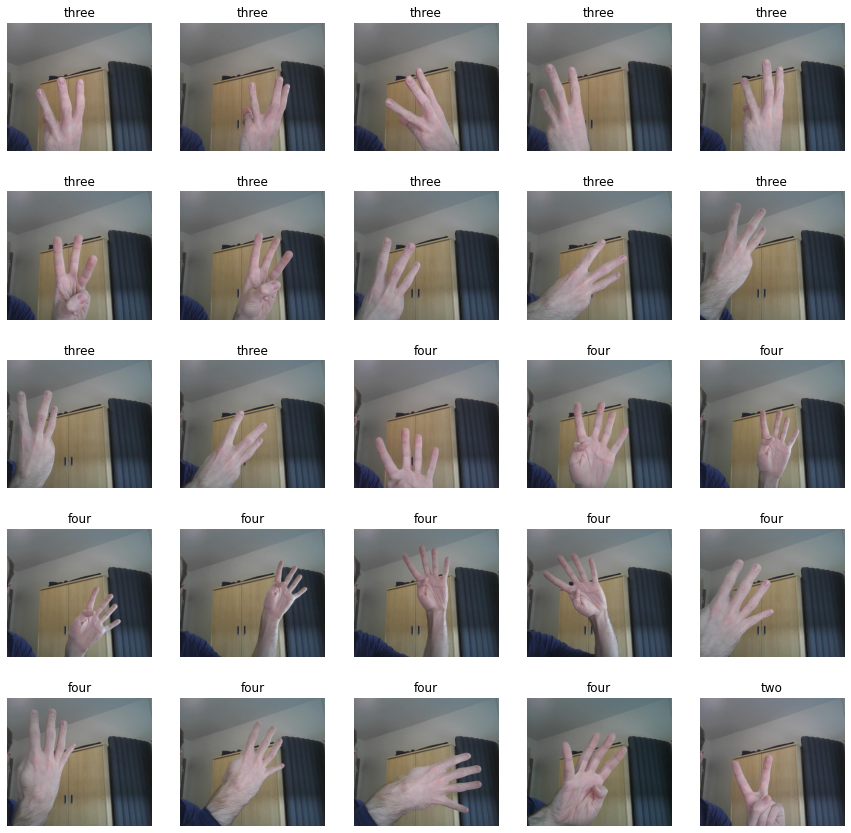

In [7]:
that_other_dls.valid.show_batch(max_n=25,nrows=5, unique = False)

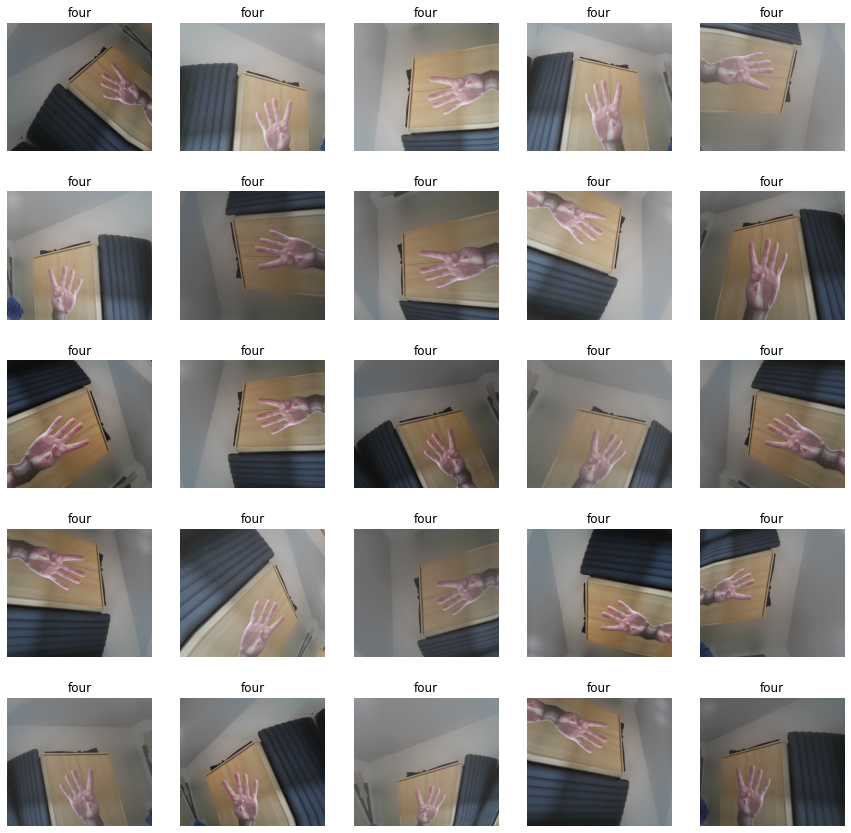

In [8]:
that_other_dls.train.show_batch(max_n=25,nrows=5, unique = True)

### Question 1: How did you choose your augmentation transfroms? Include your thought process.
*YOUR ANSWER HERE*

### Question 2: Are there any problems with your augmentations in the training data, or validation data, e.g. fingers missing, etc.?
*YOUR ANSWER HERE*


# 2. Train the classifier

## 2.1 Train a fastai cnn multi-class classifier
- ResNet18 architecture.
- accuracy as metric.
- learning rate finder to find initial learning rate.
- transfer learning with unfreezing using descriminative learning rates.
- use a batch size of 32 and the DataBlock from above.
- Use the same `set_seed()` as above to obtain reproducible results.

In [100]:
from joblib import dump, load

In [101]:
set_seed(44, reproducible=True)
machine = cnn_learner(that_other_dls,resnet18,metrics=accuracy)

SuggestedLRs(valley=0.0014454397605732083)

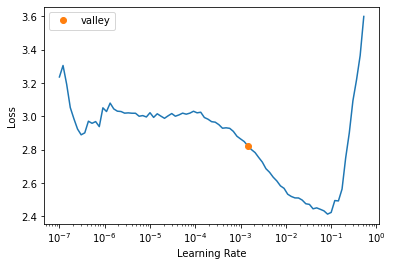

In [102]:
machine.lr_find()

In [103]:
dump(machine, '/content/gdrive/MyDrive/Colab Notebooks/lab3_models/machine_pretraining');

In [104]:
my_learner5 = load('/content/gdrive/MyDrive/Colab Notebooks/lab3_models/machine_pretraining')

In [105]:
set_seed(44, reproducible=True)
my_learner5.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.845886,3.321446,0.222222,00:05
1,2.558985,3.477554,0.349206,00:05
2,2.416100,3.387793,0.380952,00:05


In [106]:
dump(my_learner5, '/content/gdrive/MyDrive/Colab Notebooks/lab3_models/freeze_trained');

In [107]:
post_freeze_learner = load('/content/gdrive/MyDrive/Colab Notebooks/lab3_models/freeze_trained')

In [108]:
post_freeze_learner.unfreeze()

SuggestedLRs(valley=0.00010964782268274575)

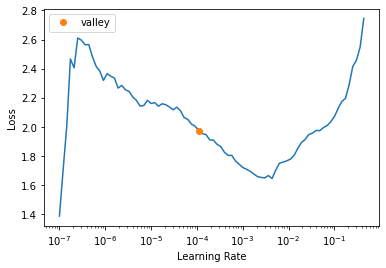

In [109]:
set_seed(44, reproducible=True)
post_freeze_learner.lr_find()

In [110]:
dump(post_freeze_learner, '/content/gdrive/MyDrive/Colab Notebooks/lab3_models/post_freeze_learner');

In [111]:
training_learner = load('/content/gdrive/MyDrive/Colab Notebooks/lab3_models/post_freeze_learner');

In [112]:
training_learner.unfreeze()

In [ ]:
# Run a large number of epochs for testing.

In [113]:
set_seed(44, reproducible=True)
training_learner.fit_one_cycle(20, lr_max=slice(5e-5,2e-4))

epoch,train_loss,valid_loss,accuracy,time
0,2.544550,3.061796,0.476190,00:06
1,2.598047,2.612541,0.428571,00:06
2,2.292209,2.619606,0.396825,00:06
3,2.069289,2.931147,0.333333,00:06
4,1.831918,2.244726,0.539683,00:06
5,1.698326,2.542966,0.555556,00:06
6,1.531437,2.724329,0.539683,00:06
7,1.461385,1.736094,0.634921,00:06
8,1.372854,1.498980,0.634921,00:06
9,1.252133,1.434600,0.682540,00:06


In [ ]:
# 17 looks like the correct number of epochs.

In [114]:
training_learner_revisited = load('/content/gdrive/MyDrive/Colab Notebooks/lab3_models/post_freeze_learner');

In [115]:
training_learner_revisited.unfreeze()

In [116]:
# This is the final version.

In [118]:
set_seed(44, reproducible=True)
training_learner_revisited.fit_one_cycle(17, lr_max=slice(5e-5,2e-4))

epoch,train_loss,valid_loss,accuracy,time
0,2.093294,2.708322,0.428571,00:06
1,2.164948,2.583678,0.396825,00:06
2,1.917305,2.436308,0.444444,00:06
3,1.766093,1.812645,0.571429,00:06
4,1.621989,1.895635,0.571429,00:06
5,1.502301,1.343536,0.650794,00:06
6,1.380478,1.495093,0.634921,00:06
7,1.282665,1.391315,0.666667,00:06
8,1.191832,1.150090,0.746032,00:06
9,1.133720,1.169843,0.714286,00:06


### Question 3: How did you select the number of epochs and learning rates? 
The intial learning rate was selected by finding the learning rate at the lowest spot on the first loss graph and dividing that value by 10.

The learning rates for the descriminitive learning was found my examining the second loss graph. were found by locating a spot well before the sharp upwad curve at around loss = 10^-2 on the second loss graph, and picking points on either side of it.




## 2.2 Experiment with different batch sizes
Using the pipeline, number of epochs, learning rates from above, re-run the pipeline with a batch size of 16, 64

In [57]:
# The batch size 16 version.

In [149]:
dls_16 = these_here_fingers.dataloaders(export_path, bs = 16);

In [150]:
set_seed(44, reproducible=True)
learner2_2 = cnn_learner(dls_16,resnet18,metrics=accuracy)

In [151]:
set_seed(44, reproducible=True)
learner2_2.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.898680,2.738051,0.412698,00:05
1,2.631067,2.059219,0.396825,00:05
2,2.320917,1.884605,0.444444,00:05


In [152]:
learner2_2.unfreeze()

In [153]:
learner2_2.fit_one_cycle(17, lr_max=slice(5e-5,2e-4))

epoch,train_loss,valid_loss,accuracy,time
0,2.057958,1.393226,0.492063,00:06
1,1.804948,1.154261,0.587302,00:06
2,1.672992,1.170554,0.650794,00:06
3,1.640678,1.670171,0.539683,00:06
4,1.481420,0.961228,0.698413,00:06
5,1.316759,1.013392,0.634921,00:06
6,1.239295,1.084024,0.682540,00:06
7,1.107895,0.753675,0.746032,00:06
8,0.977807,0.892049,0.746032,00:06
9,0.901701,0.860668,0.761905,00:06


In [63]:
# The batch size 64 version

In [154]:
dls_64 = these_here_fingers.dataloaders(export_path, bs = 64);

In [155]:
set_seed(44, reproducible=True)
learner2_2_64 = cnn_learner(dls_64,resnet18,metrics=accuracy)

In [156]:
set_seed(44, reproducible=True)
learner2_2_64.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.907804,3.114902,0.174603,00:05
1,2.550422,2.951740,0.301587,00:05
2,2.350288,2.689225,0.333333,00:05


In [157]:
learner2_2_64.unfreeze()

In [158]:
learner2_2_64.fit_one_cycle(17, lr_max=slice(5e-5,2e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.891814,2.481874,0.396825,00:06
1,1.789456,2.157319,0.460317,00:06
2,1.735664,1.899179,0.523810,00:06
3,1.734446,1.817239,0.476191,00:06
4,1.691615,1.906144,0.476191,00:06
5,1.558816,1.808849,0.507937,00:06
6,1.454307,1.764187,0.555556,00:06
7,1.407702,1.765295,0.539683,00:06
8,1.325442,1.815234,0.539683,00:06
9,1.243007,1.836554,0.523810,00:06


### Question 4: Keeping number of epochs and learning rates the same, how are validation loss and accuracy effected by the increase and decrease of batch size? 
For a batch size of sixteen validation loss shows a clear downward trend even after seventeen epochs. Accurracy shows some flucation, but is generally maintains itself at a high level in the later epochs. This is a better performance than the batch size 32 version which struggled get such high validation scores and showed more fluctuation in validation loss.
<br><br>
For a batch size of 64 validation loss also shows a smooth downward trend, however, even after 17 epochs the accuracy is still low when compared to the other batch sizes. Since accuarcy is still rising smoothely after 17 epochs, it seems liekly that this batch size would benefit from more training.

# 3. Analyze model performance
Retrain the model with batch size of 32 from the previous section.

Plot the confusion matrix.

In [119]:
dls_final = these_here_fingers.dataloaders(export_path, bs = 32);

In [120]:
set_seed(44, reproducible=True)
final_learner = cnn_learner(dls_final,resnet18,metrics=accuracy)

In [121]:
set_seed(44, reproducible=True)
final_learner.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.750567,4.111659,0.190476,00:05
1,2.779649,3.234741,0.317460,00:05
2,2.565422,2.884859,0.333333,00:05


In [122]:
final_learner.unfreeze()

In [123]:
set_seed(44, reproducible=True)
final_learner.fit_one_cycle(17, lr_max=slice(5e-5,2e-4))

epoch,train_loss,valid_loss,accuracy,time
0,2.901831,2.055649,0.476190,00:06
1,2.594892,1.467386,0.555556,00:06
2,2.254684,1.324479,0.634921,00:06
3,2.002709,1.369784,0.666667,00:06
4,1.827730,1.365260,0.650794,00:06
5,1.659325,1.415596,0.634921,00:06
6,1.524013,1.717036,0.587302,00:06
7,1.425171,1.560999,0.634921,00:06
8,1.333193,1.195766,0.682540,00:06
9,1.213977,1.016798,0.730159,00:06


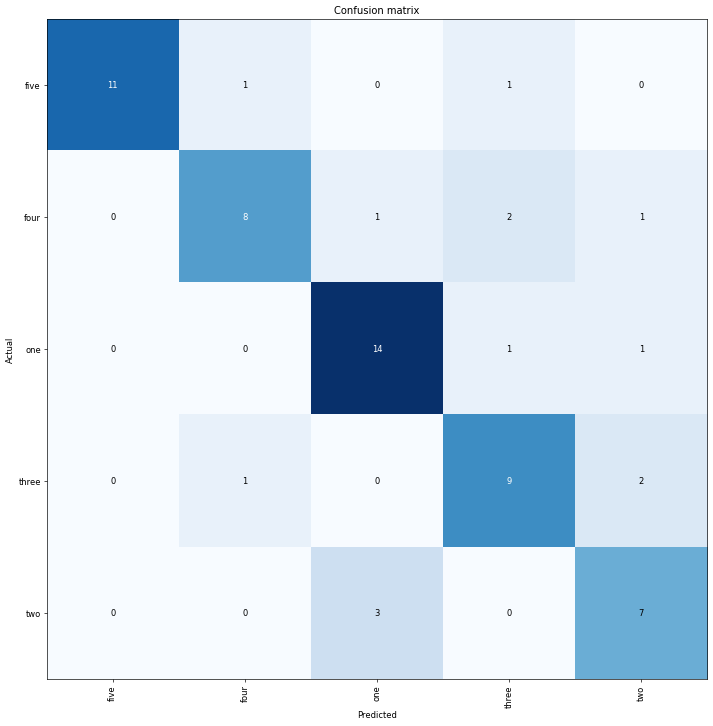

In [125]:
interp = ClassificationInterpretation.from_learner(final_learner)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# 4. Save the best model to file
Save the model using `learn.export()` as `.pkl` file. Verify that the model can be reloaded and used to make predictions.

In [ ]:
final_learner.export('/content/gdrive/MyDrive/Colab Notebooks/lab3_models/final_learner.pkl')

In [133]:
learn =  load_learner('/content/gdrive/MyDrive/Colab Notebooks/lab3_models/final_learner.pkl')


In [148]:
from fastai import vision
print(learn.predict(plt.imread('/content/gdrive/MyDrive/Colab Notebooks/lab3_pictures/train/one/00000000.jpg')))

('one', TensorBase(2), TensorBase([6.4524e-08, 1.1655e-06, 9.9062e-01, 9.0230e-03, 3.5171e-04]))


In [ ]:
# Looks like it works.

# 5. Summary and Conclusion

Summarize:
- Augmentations used<br><br>
Augmentations used include: flipping, rotation, zooming, altering lighting, warping, and reflecting. 
- Training strategy, including batch size, number of epochs and learning rates.<br><br>
A batch size of 32 was used in training the final model.<br>
The final model was trained for 3 epochs at learning rate of 1e-2 while still frozen. After the model was unfrozen it was trained for 17 epochs with a descriminative learning rate set to lr_max=slice(5e-5,2e-4).

- Accuracy achieved, summary of confusion matrix<br><br>
Final accuracy achieved was 77.8%. The confusion matrix shows no strong pattern in the fingure cambinations that the model struggles with--except tht it does tend to mistake twos for ones. Rather, the model seems to have trouble trouble with all combinations. This makes it seem very likely that the model would benefit from beaing trained with larger number of pictures.



Conclusion:
- Are you satisfied with model performance? Why, why not?

Given that the model has relatively few images to work with and still a validation accurracy of 77.8% I think it does very well. I am satisfied.

# 6.Reflection
Include a sentence or two about
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating

while working on this assignment.

### My reflection.

It took a weirdly long time to get this lab to work properly. Very frustraiting.
